<a href="https://colab.research.google.com/github/JoonhyeonKim/Fun_with_practicing_DS/blob/main/BinaryClassification_exercies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1]:
from torch import nn


In [3]:
print(device)


cuda


In [4]:
from sklearn.datasets import make_circles, make_moons


In [6]:
sample_size = 1000
RANDOM_SEED = 42

In [57]:
X, y = make_moons(n_samples=sample_size,
           noise=0.03,
           random_state=RANDOM_SEED)


In [58]:
X_, y_ = make_circles(n_samples=sample_size,
           noise=0.03,
           random_state=RANDOM_SEED)


In [59]:
X, y = X+X_, y


In [60]:
print('X shape: ', X.shape, '\ny shape: ', y.shape)


X shape:  (1000, 2) 
y shape:  (1000,)


In [61]:
# Turn data into a Dataframe
import pandas as pd

In [62]:
moon_circle = pd.DataFrame(
    {"X1": X[:,0], # first feature
     "X2": X[:,1], # second feature
     "label": y}
)


In [63]:
moon_circle.head(10)

,X1,X2,label
0,0.744914,0.622462,1
1,0.198415,-0.320497,1
2,0.103134,-0.251914,1
3,0.019037,0.316498,1
4,-0.403113,-0.367924,0
5,0.099896,0.323456,1
6,0.281236,0.594111,1
7,0.757025,0.583656,1
8,1.457188,-1.074663,1
9,0.550112,1.807931,0


In [64]:
moon_circle.label.nunique()

2

In [65]:
moon_circle.label.value_counts()


1    500
0    500
Name: label, dtype: int64

In [66]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

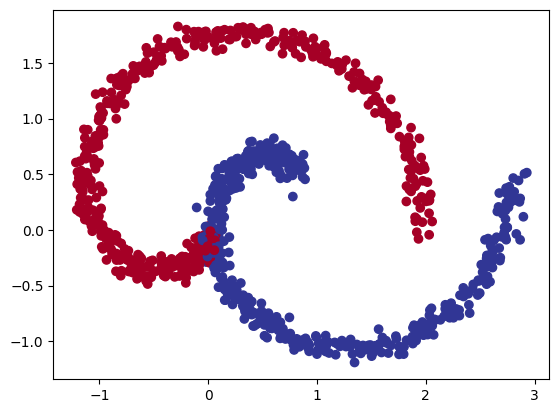

In [67]:
plt.scatter(
    x=moon_circle.X1,
    y=moon_circle.X2,
    c=moon_circle.label,
    cmap=plt.cm.RdYlBu
);

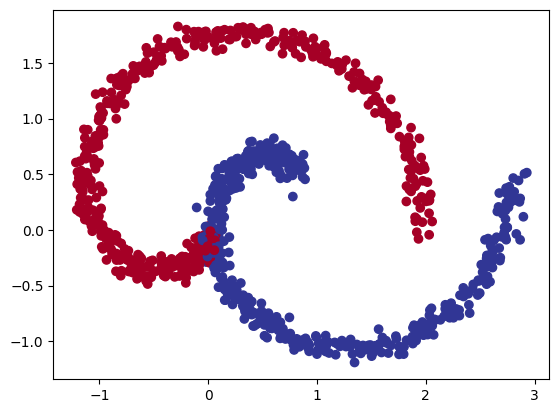

In [68]:
plt.scatter(
    x=X[:,0], # all instance of first feature
    y=X[:,1], # all instance of second feature
    c=y, # classification given by y
    cmap=plt.cm.RdYlBu
)

In [69]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [70]:
# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [72]:
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

In [73]:
# Inherit from nn.Module to make a model capable of fitting the data
class Mooncircle_modelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    self.linear_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    self.linear_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    self.relu = nn.ReLU()

  def forward(self, x):
    z = self.linear_1(x)
    z = self.relu(z)
    z = self.linear_2(z)
    z = self.relu(z)
    z = self.linear_3(z)
    return z

In [74]:
# (instance, features)(features,features)(featurures, classes)


In [75]:
moon_circle = Mooncircle_modelV0(
    input_features=2,
    output_features = 1,
    hidden_units = 10
).to(device)


In [76]:
print(moon_circle)


Mooncircle_modelV0(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [77]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=moon_circle.parameters(), lr=0.1)

In [78]:
# Calculate accuracy (a classification evaluation metric)
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc


In [79]:
# What's coming out of model?
y_logits = moon_circle(X_train.to(device))

In [80]:
print('Logits: ', y_logits[:6])


Logits:  tensor([[ 0.0051],
        [ 0.0183],
        [-0.0017],
        [ 0.0038],
        [ 0.0225],
        [ 0.0094]], device='cuda:0', grad_fn=<SliceBackward0>)


In [81]:
y_probs = torch.sigmoid(y_logits)


In [82]:
print('Probabilities: ', y_probs[:6])


Probabilities:  tensor([[0.5013],
        [0.5046],
        [0.4996],
        [0.5010],
        [0.5056],
        [0.5023]], device='cuda:0', grad_fn=<SliceBackward0>)


In [83]:
y_label = torch.round(torch.sigmoid(moon_circle(X_train.to(device))))


In [84]:
print('y_label: ', y_label[:6])


y_label:  tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SliceBackward0>)


For binary classification task

In [85]:
torch.manual_seed(RANDOM_SEED)


In [86]:
epochs = 1000


In [87]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


In [88]:
for epoch in range(epochs):
  y_logits = moon_circle(X_train).squeeze() # for binary classification task
  y_prob = torch.sigmoid(y_logits)
  y_pred = torch.round(y_prob)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred=y_pred,
                    y_true=y_train.int()) # integer typecast because y_pred is 0 or 1

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  moon_circle.eval()
  with torch.inference_mode():
    test_logits = moon_circle(X_test).squeeze()
    test_prob = torch.sigmoid(test_logits)
    test_pred = torch.round(test_prob)

    test_loss = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn(y_pred=test_pred,
                           y_true=y_test.int())

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69483, Accuracy: 52.12% | Test Loss: 0.69458, Test Accuracy: 54.50%
Epoch: 100 | Loss: 0.53751, Accuracy: 70.25% | Test Loss: 0.54879, Test Accuracy: 67.50%
Epoch: 200 | Loss: 0.36382, Accuracy: 85.62% | Test Loss: 0.36833, Test Accuracy: 84.00%
Epoch: 300 | Loss: 0.21366, Accuracy: 93.00% | Test Loss: 0.20865, Test Accuracy: 94.50%
Epoch: 400 | Loss: 0.16554, Accuracy: 93.50% | Test Loss: 0.16501, Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.14570, Accuracy: 94.00% | Test Loss: 0.14728, Test Accuracy: 94.00%
Epoch: 600 | Loss: 0.13239, Accuracy: 94.88% | Test Loss: 0.13415, Test Accuracy: 94.00%
Epoch: 700 | Loss: 0.12045, Accuracy: 95.25% | Test Loss: 0.12147, Test Accuracy: 96.00%
Epoch: 800 | Loss: 0.10876, Accuracy: 96.00% | Test Loss: 0.10863, Test Accuracy: 96.50%
Epoch: 900 | Loss: 0.09747, Accuracy: 96.62% | Test Loss: 0.09558, Test Accuracy: 97.00%


In [89]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

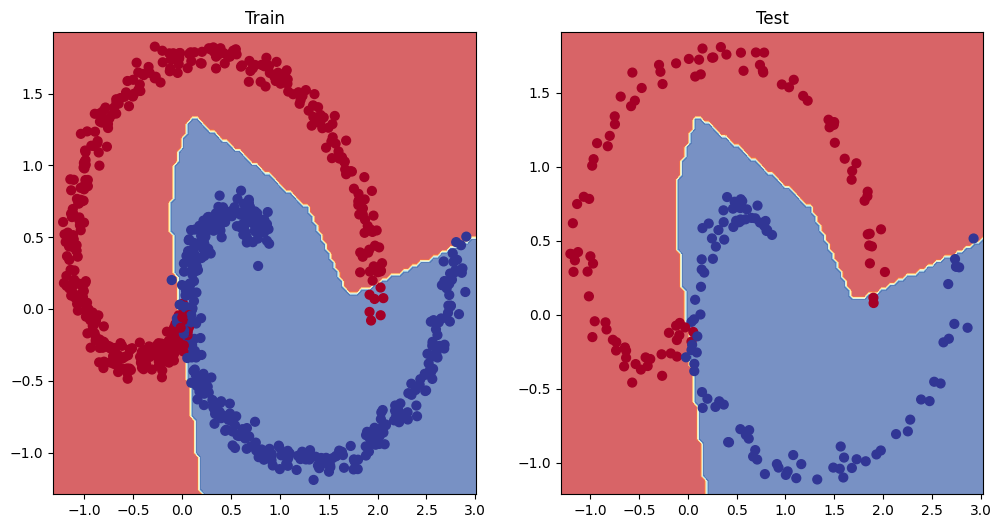

In [90]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_circle, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_circle, X_test, y_test)